<a href="https://colab.research.google.com/github/KyungRyeolBaek/study/blob/main/AI%20study/%EC%B9%98%EC%95%84/tooth_CNN_project_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# tooth_CNN

# 모듈 import

In [17]:
import numpy as np
import pandas as pd
import keras, os, math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib 
from tensorflow.keras import datasets, layers, models

# GPU 작동 방법

In [2]:
# Ture가 나와야 GPU가 작동 되는 중 !
device_lib.list_local_devices() 
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# 파라미터 설정

In [3]:
# parameter
# image_num = [0, 1, 2, 3, 4, 5, 6, 7, 8]       # 전체 이미지
train_image_num = [1, 2, 3, 4, 5, 6, 7, 8]    # 트레이닝 이미지 범위 [1, 2, 3, 4, 5, 6, 7, 8]
# test_image_num = 0                            # 테스트 이미지 숫자 [0]
X_shape = [20, 21]                            # X 형태 [행, 열] -> 트레이닝 크기
# y_shape = 5                                   # y 형태 -> 트레이닝 결과 크기
# y_test_range = [100, 110]                     # y_test 예측 범위 [100 ~ 110]
epoch = 10                                  # epoch 횟수

# Test Data Setting

In [4]:
# 현재 디렉토리 내에서 파일 경로 설정
path = "./test"
test_file = os.listdir(path)

# 리스트 내 checkpoint가 있으면 제거
if '.ipynb_checkpoints' in test_file:
  test_file.remove('.ipynb_checkpoints')
  
print(test_file) # 경로 내에 모든 파일 출력 ['sino_wmetal.txt'] 

['sino_wmetal.txt']


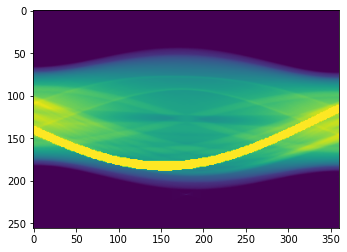

In [5]:
df = pd.read_table('./test/' + test_file[0], sep = ',', header = None) # Test Data 불러오기

plt.imshow(df); # 테스트 이미지 

(256, 380)

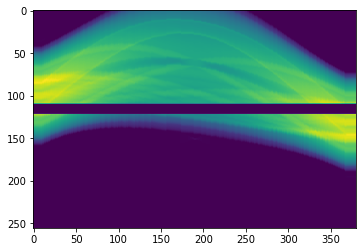

In [6]:
### 마스크, metal_line, padding, y_shape 설정 ----------------------------------
mask_value = 200 # 마스크에 설정 된 값
mask_list = [] # 마스크 리스트 만들기

# mask_value에 맞는 부위 mask_list에 추가
for i in range(360):
  temp = []
  for i, k in zip(df.iloc[:, i]== mask_value, df.iloc[:, i].index):
    if i == True:
      temp.append(k)
  mask_list.append(temp)

y_shape = 0 # 예측 범위 변수
padding = 0 # X_shape에 따른 data 양 옆을 채울 패딩 추가
metal_line = [] # mask_list를 따라 한줄씩 선 따기
count = 0
for i in mask_list[:]:
  mid = int((max(i) - min(i))/2)

  # padding의 크기 = 
  if mid > padding:
    padding = mid

  if (max(i)-min(i)) % 2 == 0:
    metal_line.append(min(i) + mid)

  else:
    metal_line.append(min(i) + mid + 1)

  count += 1
metal_shift = [i - min(metal_line) for i in metal_line]
### ----------------------------------------------------------------



# 데이터 전처리
for i, j, k in zip(df.columns, metal_shift, metal_line):
      df.iloc[k - 1 - padding : k + padding + 1, i] = 200
      df[i] = df[i].shift(-j, fill_value = 0)
    
y_test_range = [min(df[df.iloc[:, 0] == 200].index), max(df[df.iloc[:, 0] == 200].index) + 1]
y_shape = y_test_range[1] - y_test_range[0]

df.iloc[y_test_range[0] : y_test_range[1], :] = 0
df = df / math.ceil(df.max().max())

df_temp_left = pd.DataFrame()
df_temp_right = pd.DataFrame()
for i in range(int(X_shape[1]/2)):
    df_temp_left[i] = df[0]
    df_temp_right[i] = df[359]

df_left = pd.concat([df_temp_left, df], axis = 1)
df = pd.concat([df_left, df_temp_right], axis = 1)

plt.imshow(df)

df.shape

# Training Data Setting

In [7]:
# 현재 디렉토리 내에서 파일 경로 설정
path = "./train"
file_lst = os.listdir(path)
file_lst.sort()
# 리스트 내 checkpoint가 있으면 제거
if '.ipynb_checkpoints' in file_lst:
  file_lst.remove('.ipynb_checkpoints')
# 경로 내에 모든 파일 출력
print(file_lst) # ['test1.text','test2.text','test3.text','.ipynb_checkpoints','test4.text','test.ipynb','test5.text']

# 경로 내에 각각의 파일을 출력
for file in file_lst:
    filepath = path + '/' + file
    print(file)

['sino_1.txt', 'sino_2.txt', 'sino_3.txt', 'sino_4.txt', 'sino_5.txt', 'sino_6.txt', 'sino_7.txt', 'sino_8.txt']
sino_1.txt
sino_2.txt
sino_3.txt
sino_4.txt
sino_5.txt
sino_6.txt
sino_7.txt
sino_8.txt


In [10]:
# 이미지 양쪽 열 10개씩 늘림.
for num, file in zip(range(len(file_lst)), file_lst): 
    globals()['df{}'.format(num)] = pd.read_table(path + '/' + file, sep=',', header = None)
    for i, j in zip(globals()['df{}'.format(num)].columns, metal_shift):
      globals()['df{}'.format(num)][i] = globals()['df{}'.format(num)][i].shift(-j, fill_value = 0)
    globals()['df{}'.format(num)] = globals()['df{}'.format(num)] / math.ceil(globals()['df{}'.format(num)].max().max())


for num in range(len(file_lst)):
    df_temp_left = pd.DataFrame()
    df_temp_right = pd.DataFrame()
    for i in range(int(X_shape[1]/2)):
        df_temp_left[i] = globals()['df{}'.format(num)][0]
        df_temp_right[i] = globals()['df{}'.format(num)][359]

    df_left = pd.concat([df_temp_left, globals()['df{}'.format(num)]], axis = 1)
    globals()['df{}'.format(num)] = pd.concat([df_left, df_temp_right], axis = 1)
    
# train셋, test셋으로 나누어 줍니다. X는 입력 변수, y는 출력 변수
X_train_org, X_test_org, y_train_org, y_test_org = [], [], [], []

아래 셀 런타임 오래 걸림

In [12]:
# X 형태 (x_shape[0]/2 + x_shape[0]/2, x_shape[1]), y 형태 (y_shape)
for num in range(len(file_lst)):
    for i in range(globals()['df{}'.format(num)].shape[1] - X_shape[1] + 1):                             # i, 열, 1
        for j in range(globals()['df{}'.format(num)].shape[0] - X_shape[0] - y_shape):                # j, 행, 0
            X_train_org.append(pd.concat([globals()['df{}'.format(num)].iloc[j:j+int(X_shape[0]/2), 0+i:X_shape[1]+i], globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2)+y_shape:j+int(X_shape[0]/2)+y_shape+int(X_shape[0]/2), 0+i:X_shape[1]+i]], axis = 0))           # 아래
            if X_shape[1] % 2 == 0:
                y_train_org.append(globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2):j+int(X_shape[0]/2)+y_shape, i+int(X_shape[1]/2)])
            else:
                y_train_org.append(globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2):j+int(X_shape[0]/2)+y_shape, i+int(X_shape[1]/2)+1])

for i in range(df.shape[1] - X_shape[1] + 1):
    X_test_org.append(pd.concat([df.iloc[y_test_range[0] - int(X_shape[0]/2):y_test_range[0], 0+i:X_shape[1]+i], df.iloc[y_test_range[1]:y_test_range[1] + int(X_shape[0]/2), 0+i:X_shape[1]+i]], axis = 0))
    if X_shape[1] % 2 == 0:
        y_test_org.append(df.iloc[y_test_range[0]:y_test_range[1], i+int(X_shape[1]/2)])
    else:
        y_test_org.append(df.iloc[y_test_range[0]:y_test_range[1], i+int(X_shape[1]/2)+1])

X_train_org, X_test_org, y_train_org, y_test_org = np.array(X_train_org), np.array(X_test_org), np.array(y_train_org), np.array(y_test_org)

In [13]:
# RGB 값을 추가 합니다. 우선 흑백으로 설정 하였습니다.
# train 형태 : ((8*354*245, x_shape[0], x_shape[1], 1)), test 형태 : ((354, x_shape[0], x_shape[1], 1))
# tensorflow는 3차원만 지원하므로 3차원 형태로 reshape 해줘야 합니다.
X_train = X_train_org.reshape((len(file_lst)*(df.shape[1]-X_shape[1] + 1)*(df.shape[0]-X_shape[0]-y_shape), X_shape[0], X_shape[1], 1))
X_test = X_test_org.reshape(((df.shape[1]-X_shape[1] + 1), X_shape[0], X_shape[1], 1))
y_train = y_train_org
y_test = y_test_org

In [14]:
len(file_lst), (df.shape[1]-X_shape[1] + 1), (df.shape[0]-X_shape[0]-y_shape) ,20 , 21 , 1

(8, 360, 224, 20, 21, 1)

In [15]:
X_test_org.shape

(360, 20, 21)

In [20]:
# model 생성
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_shape[0], X_shape[1], 1), padding = 'same'))
# MaxPooling2D(filter)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(y_shape))
model.summary()

# overfitting을 방지하기 위해서 학습 중 early stop을 수행하기 위한 코드입니다.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 모델 검증
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4) # 검증 데이터 손실이 4회 증가하면 학습 조기 종료
mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True) # 검증 데이터의 정확도가 이전보다 좋아질 경우에만 모델 저장

# model 구성
model.compile(optimizer='adam',
            loss='mse',
            metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 20, 21, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 5, 5, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [26]:
# 모델 훈련
history = model.fit(X_train, y_train, batch_size = 10, epochs=epoch, callbacks=[es, mc], validation_data=(X_test, y_test), verbose = 1)

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)      # test 데이터를 넣었을 때의 loss, acc
print(test_acc)   # 정확도

64512/64512 [==============================] - 789s 12ms/step - loss: 5.0867e-04 - accuracy: 0.4079 - val_loss: 0.4654 - val_accuracy: 0.4583
12/12 - 0s - loss: 0.4654 - accuracy: 0.4583
0.4583333432674408


In [29]:
# 저장된 모델인 'best_model.h5'를 로드하고, 성능을 평가
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

# 에포크마다 변화하는 훈련 데이터와 검증 데이터(테스트 데이터)의 손실을 시각화
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

NameError: ignored

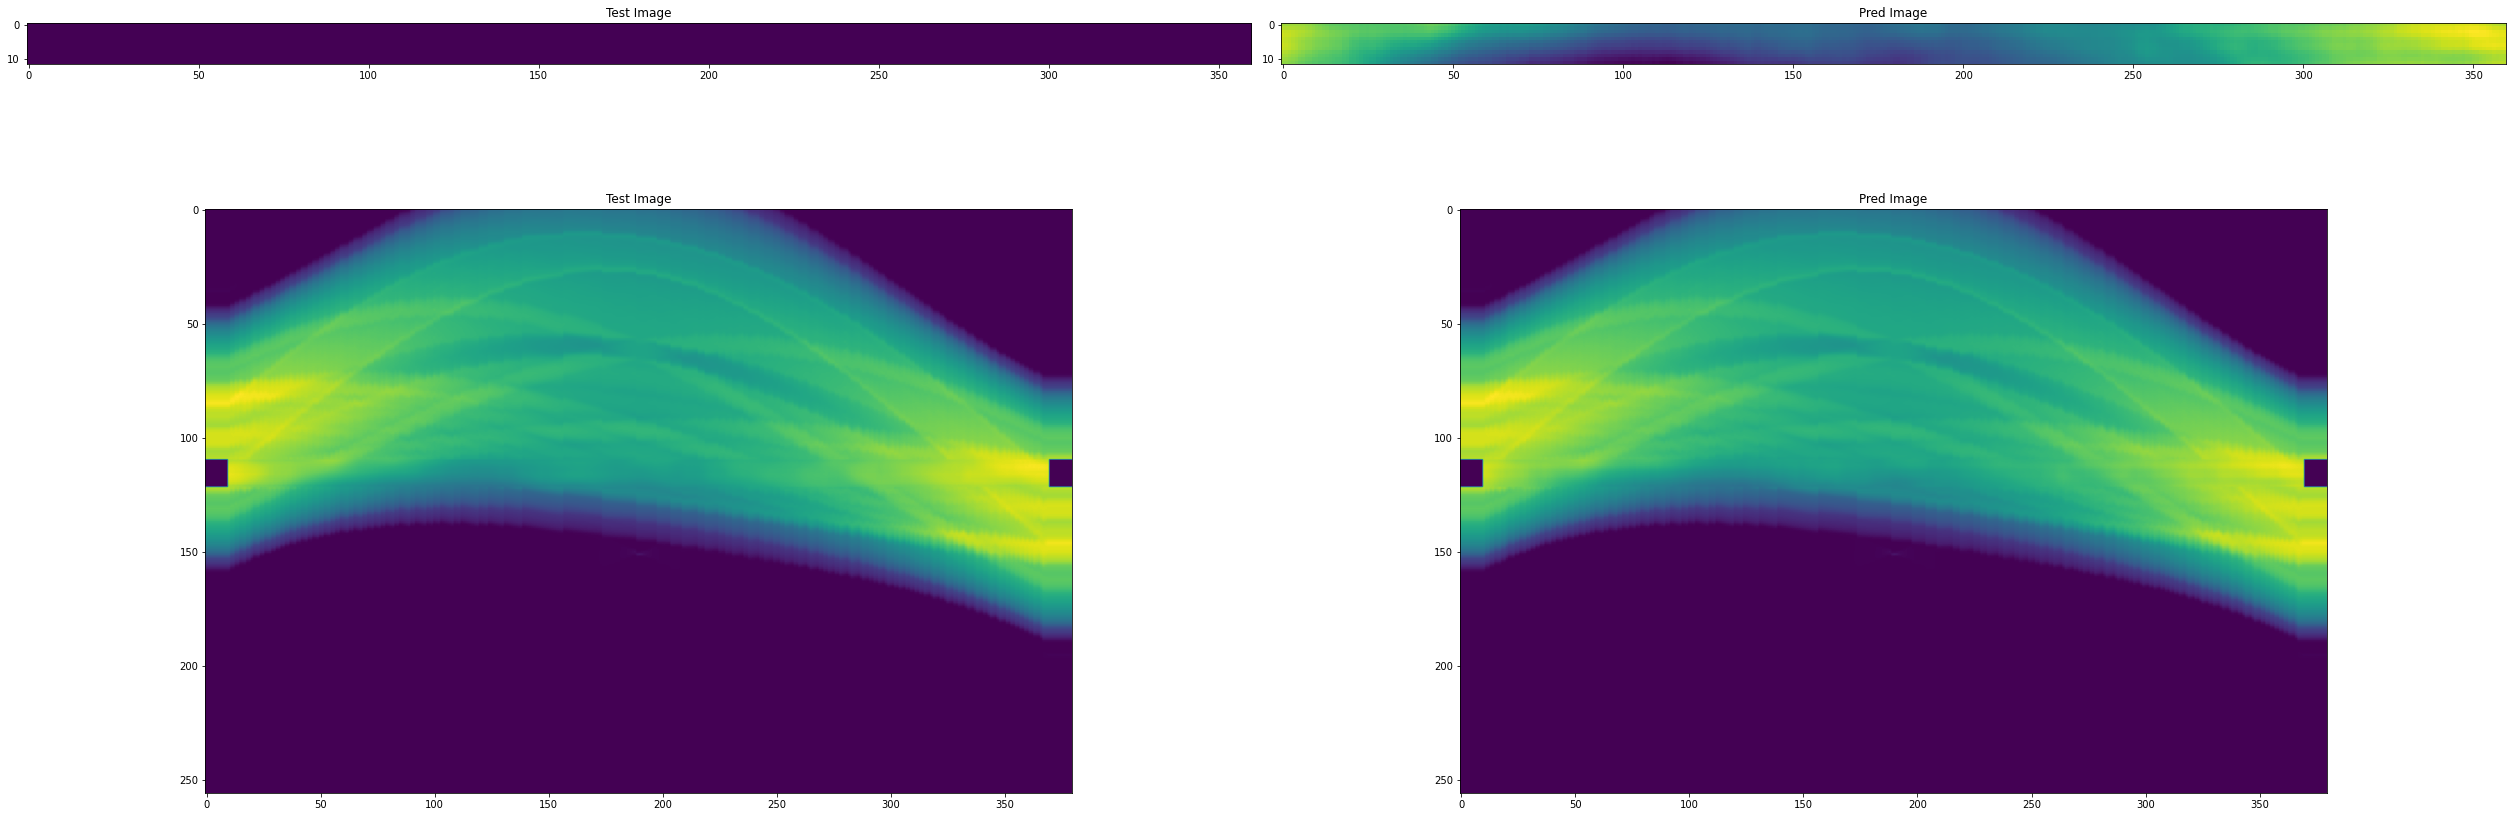

In [27]:
# 모델 예측
pred = model.predict(X_test)    # 예측 데이터를 ()안에 넣으면 됩니다.

figure, axes = plt.subplots(nrows=2, ncols=2, figsize = (35, 15))
axes[0][0].set_title('Test Image')
axes[0][0].imshow(y_test_org.T)
axes[0][1].set_title('Pred Image')
axes[0][1].imshow(pred.T)
axes[1][0].set_title('Test Image')
axes[1][0].imshow(df)
df_test_img = df
if X_shape[1] % 2 == 0:
    df_test_img.iloc[y_test_range[0]:y_test_range[1], 0+int(X_shape[1]/2):df.shape[1]-int(X_shape[1]/2)] = pred.T
else:
    df_test_img.iloc[y_test_range[0]:y_test_range[1], 0+int(X_shape[1]/2):df.shape[1]-int(X_shape[1]/2)] = pred.T
axes[1][1].set_title('Pred Image')
axes[1][1].imshow(df_test_img)
figure.colorbar;

figure.tight_layout()
plt.show()

예측 결과 원본 데이터에 덮어쓰기

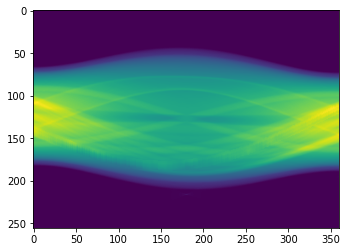

In [28]:
df = pd.read_table('./test/' + test_file[0], sep = ',', header = None)
for i, j, k in zip(df.columns, metal_shift, metal_line):
    df = df / math.ceil(df.max().max())
    df.iloc[k - 1 - padding : k + padding + 1, i] = pred[i]
        
plt.imshow(df)

In [ ]:
df.shape

(256, 360)

In [ ]:
# 주신 line이랑 제가 따로 중심부분만 딴 부분이랑 중간 중간 몇군데씩 안맞는 부분 있어서 제가 따로 딴 line을 사용 했습니다.
df_line == [i - min(metal_line) for i in metal_line]

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,True,True,True,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [ ]:
# mat 저장
import scipy.io as sio
# sio.savemat('df_test_img.mat', {'values' : df_test_img.values})